# imports e transferência da base de disco para RAM

Dicionarios de dados: https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SRAG/pdfs/dicionario_de_dados_srag_hosp_17_02_2022.pdf

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.metrics import plot_confusion_matrix,confusion_matrix,ConfusionMatrixDisplay,recall_score, precision_score, accuracy_score, f1_score


In [ ]:
from google.colab import drive                                                                                                                                                                                               #1
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


É preciso ter a base de dados ["full_base.csv"](https://drive.google.com/drive/folders/1Xw9-uMM_saHUHRrNYDw9d7BKuEbrdgxc?usp=sharing) baixada e na home do seu drive para conseguir rodar o classificador

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BasesSUS/full_base.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (15,16,17,50) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Adaptando dados para classificador bayesiano
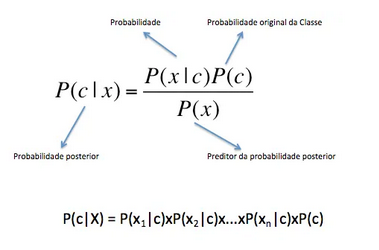

Nossa base de dados possui algumas variáveis não categóricas como a coluna NU_IDADE_N que é preenchida com a idade do paciente e variáveis categóricas como, por exemplo, na coluna EVOLUCAO que indica se o caso evoluiu para cura, óbito ou óbito por outras causas. Para que os dados encontrados sejam submetidos e o classificador Naive Bayes funcione corretamente precisamos adaptá-los convertendo as features cujos dados são contínuos em categorias.

A Seguir podemos ver todas as colunas presentes em nosso dataframe:

In [ ]:
columns = df.columns
for column in columns:
  print(column)

Unnamed: 0
NU_IDADE_N
FATOR_RISC
CARDIOPATI
ASMA
PNEUMOPATI
DIABETES
IMUNODEPRE
OBESIDADE
OBES_IMC
VACINA_COV
VACINA
DT_SIN_PRI
DT_NOTIFIC
DT_NASC
DOSE_1_COV
DOSE_2_COV
DOSE_REF
DT_UT_DOSE
DT_INTERNA
DT_ENTUTI
DT_SAIDUTI
DT_EVOLUCA
UTI
HOSPITAL
EVOLUCAO
CLASSI_FIN
TOMO_RES
RES_AN
PCR_RESUL
PCR_SARS2
POS_AN_FLU
RES_IGG
RES_IGM
RES_IGA
SEM_NOT
SEM_PRI
ANO_DOSE_1_COV
ANO_DOSE_2_COV
ANO_DT_ENTUTI
ANO_DT_INTERNA
ANO_DT_NOTIFIC
ANO_DT_SIN_PRI
DIA_PRI
DIA_NOT
ONDA
OBES_MORB
FATOR_RISC_GRAVE
COMORBIDADES
COMORBIDADE_GRAVE
ULT_DOSE
TEMP_ULT_DOSE
CLASSI_COV_EXAME


A partir dessas colunas fizemos uma seleção das que poderiam ser interessantes para utilizar no nosso classificador

In [ ]:
df_selecionadas_Classificador_Bayseano = [
  'NU_IDADE_N', 
  'FATOR_RISC',
  'FATOR_RISC_GRAVE', 
  'CARDIOPATI',
  'ASMA',
  'PNEUMOPATI',
  'DIABETES',
  'IMUNODEPRE',
  'OBESIDADE',
  'UTI', 
  'EVOLUCAO', 
  'CLASSI_FIN',
  'CLASSI_COV_EXAME',
  'TEMP_ULT_DOSE',    
  'ONDA',
  "COMORBIDADES",
  'COMORBIDADE_GRAVE',
]

O classificador recebe o nome de ingênuo porque desconsidera a correlação entre as features. Por exemplos, se determinada fruta é rotulada como “Limão”, caso ela também seja descrita como “Verde” e “Redonda”, o algoritmo não vai levar em consideração a correlação entre esses fatores. Isso porque trata cada um de forma independente. Portanto, escolhemos algumas dessas colunas que acreditamos que sejam independentes.

- NU_IDADE_N
- FATOR_RISC
- UTI
- EVOLUCAO
- CLASSI_FIN
- TEMP_ULT_DOSE
- ONDA
- COMORBIDADES




#Classificação da Idade
Utilizaremos classificação semelhante à seguinte para separar as idades com base em informações deste site: 


[Classificação](https://pt.wikipedia.org/wiki/Predefini%C3%A7%C3%A3o:Faixas_et%C3%A1rias_do_Brasil)



#### **Adolescentes (11 a 14 anos)**


#### **Jovens (15 a 24)**


#### **Adultos (25 a 64)**

A classe de adultos será divida em três sub-classes:

 - Adulto Jovem (25 a 34)

 - Adulto Médio (35 a 45)

 - Adulto Experiente (46 a 64)


### **Idosos (a partir de 65)** 

A classe de idosos será divida em três sub-classes:

 - Idoso Priemira Fase (65 a 74)

 - Idoso Segunda Fase (75 a 84)

 - Idoso Terceira Fase (85 a 110)

In [ ]:
def classificarIdade(x): 
  if x <= 11:
    resp = 0
  elif x >= 12 and x <= 23:
    resp = 1
  elif x >= 24 and x <= 45:
    resp = 2
  elif x >= 46 and x <= 64:
    resp = 3
  elif x >= 65 and x <= 74:
    resp = 4
  elif x >= 75 and x <= 84:
    resp = 5
  elif x >= 85 and x <= 110:
    resp = 6
  else : 
    resp = 7
  
  return resp

In [ ]:
df['IDADE_FASE'] = df['NU_IDADE_N'].apply(lambda x: classificarIdade(x))

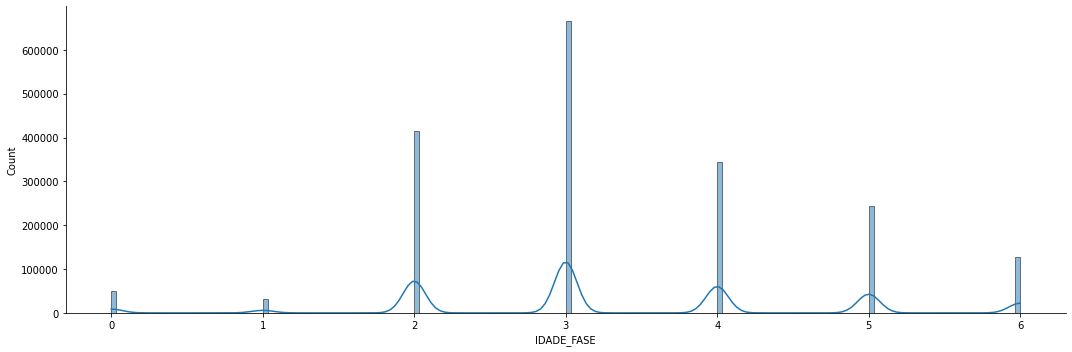

In [ ]:
sns.displot(df["IDADE_FASE"], kde = True,aspect = 3)
plt.show()

#Classificação Fator de Risco
Nessa feature podemos perceber que os dados são categóricos, se o paciente apresentar algum fator de risco o valor na coluna será 1. Caso contrário, o valor será 2. 

Apenas por padronização vamos substituir os valores por 0 e 1. 

In [ ]:
df['FATOR_RISC'].unique()

array([1., 2.])

In [ ]:
df['FATOR_RISC'] = np.where(df['FATOR_RISC'] == 2, 0, 1)

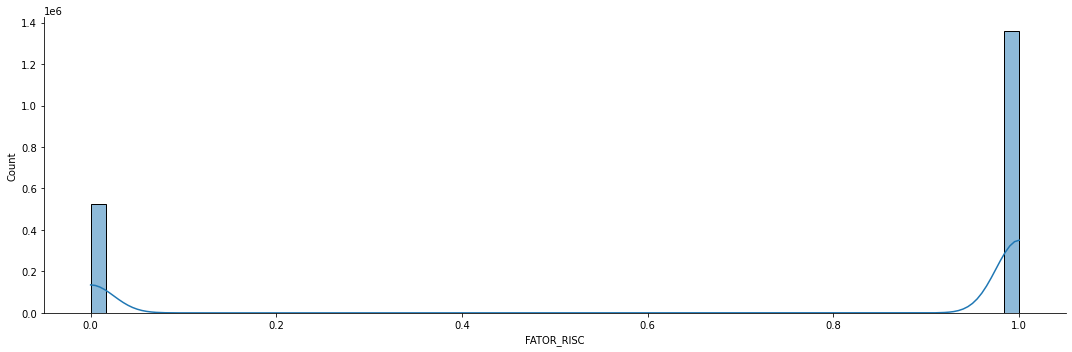

In [ ]:
sns.displot(df["FATOR_RISC"], kde = True,aspect = 3)
plt.show()

#Classificação UTI
Vamos padronizar os valores para 0 se o paciente não foi internado em UTI e 1 se o paciente foi internado.

In [ ]:
df['UTI'].unique()

array([2., 9., 1.])

In [ ]:
df['UTI'] = np.where((df['UTI'] == 2) | (df['UTI'] == 9) , 0, 1)

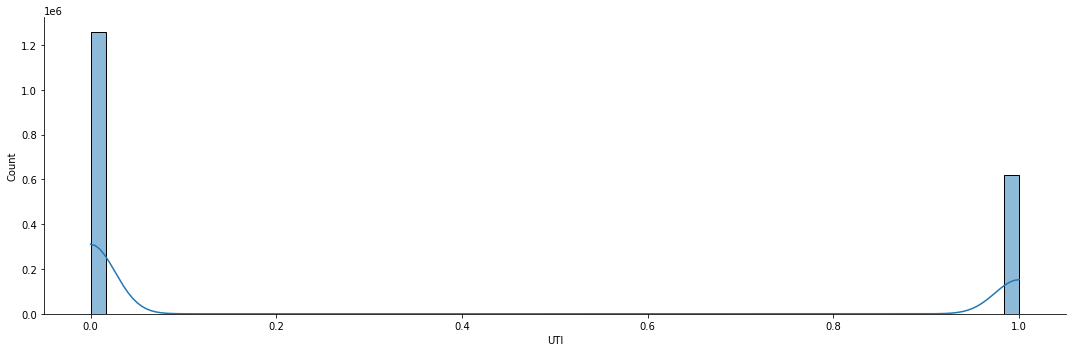

In [ ]:
sns.displot(df["UTI"], kde = True,aspect = 3)
plt.show()

#Classificação da Evolução
Essa é uma das colunas mais importantes para o nosso classificador, nela é informado se o caso evoluiu para cura (0) ou se o paciente veio a óbito (1).

In [ ]:
df['EVOLUCAO'].unique()

array([1., 2., 3.])

In [ ]:
df['EVOLUCAO'] = np.where(df['EVOLUCAO'] == 1, 0, 1)

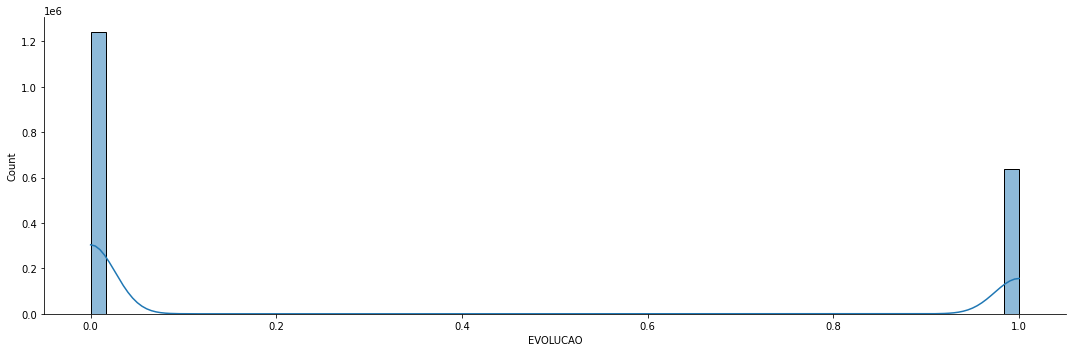

In [ ]:
sns.displot(df["EVOLUCAO"], kde = True,aspect = 3)
plt.show()

#Classificação da Onda

In [ ]:
df['ONDA']

0          0.089552
1          0.373134
2          0.955224
3          1.000000
4          0.179104
             ...   
1879939    5.000000
1879940    5.000000
1879941    5.000000
1879942    5.000000
1879943    5.000000
Name: ONDA, Length: 1879944, dtype: float64

In [ ]:
def classificarOnda(x):
  if x <= 1:
    resp = 1
  elif x > 1 and x <= 2:
    resp = 2
  elif x > 2 and x <= 3:
    resp = 3
  elif x > 3 and x <= 4:
    resp = 4
  elif x > 4 and x <= 5:
    resp = 5
  return resp

In [ ]:
df['ONDA_FASE'] = df['ONDA'].apply(lambda x: classificarOnda(x))

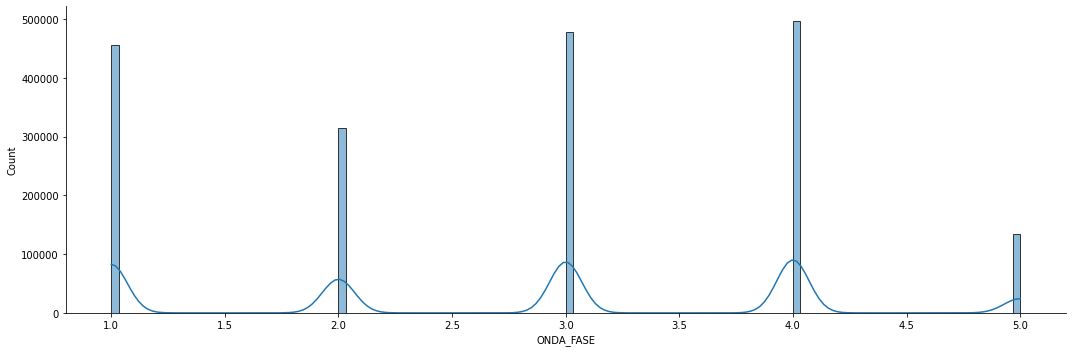

In [ ]:
sns.displot(df["ONDA_FASE"], kde = True,aspect = 3)
plt.show()

#Classificação do tempo desde a última dose


In [ ]:
df['TEMP_ULT_DOSE']

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
             ...   
1879939    203040.0
1879940     69984.0
1879941     29376.0
1879942    103680.0
1879943    251424.0
Name: TEMP_ULT_DOSE, Length: 1879944, dtype: float64

In [ ]:
maximo = df['TEMP_ULT_DOSE'].max() 
minimo = df['TEMP_ULT_DOSE'].min() 
print(minimo,maximo)

0.0 607392.0


In [ ]:
df.TEMP_ULT_DOSE = np.where(pd.isnull(df['TEMP_ULT_DOSE']),999999,df['TEMP_ULT_DOSE'])

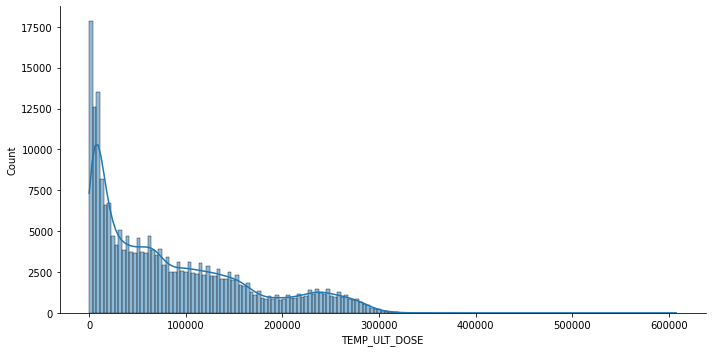

In [ ]:
sns.displot(df["TEMP_ULT_DOSE"][df["TEMP_ULT_DOSE"] != 999999], kde = True,aspect = 2)
plt.show()

In [ ]:
N = 300000/5
def classificar_tempo_ult_dose(x):
  if x < 0 or x >= 5*N:
    resp = 999999
  elif x >= 0 and x <= N:
    resp = 0
  elif x > N and x <= 2*N:
    resp = 1
  elif x > 2*N and x <= 3*N:
    resp = 2
  elif x > 3*N and x <= 4*N:
    resp = 3
  elif x > 4*N and x <= 5*N:
    resp = 4
  return resp

In [ ]:
df['CLASS_TEMP_ULT_DOSE'] = df['TEMP_ULT_DOSE'].apply(lambda x: classificar_tempo_ult_dose(x))

In [ ]:
df['CLASS_TEMP_ULT_DOSE'].value_counts()

999999    1663240
0          107314
1           48293
2           31248
3           16463
4           13386
Name: CLASS_TEMP_ULT_DOSE, dtype: int64

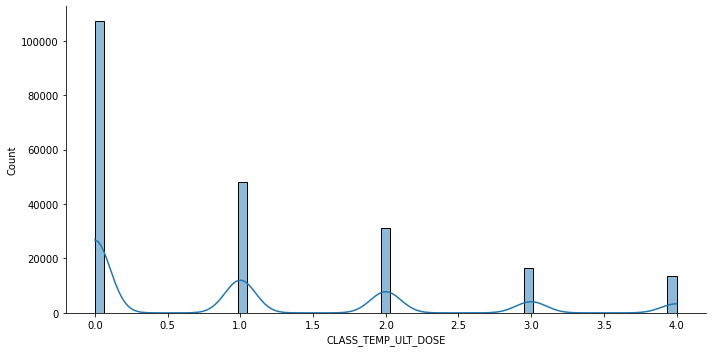

In [ ]:
sns.displot(df["CLASS_TEMP_ULT_DOSE"][df["CLASS_TEMP_ULT_DOSE"] != 999999    ], kde = True,aspect = 2)
plt.show()

#Classificação das Comorbidades

In [ ]:
df['COMORBIDADES'].unique()

array([1, 2])

In [ ]:
df['COMORBIDADES'] = np.where(df['COMORBIDADES'] == 2, 0, 1)

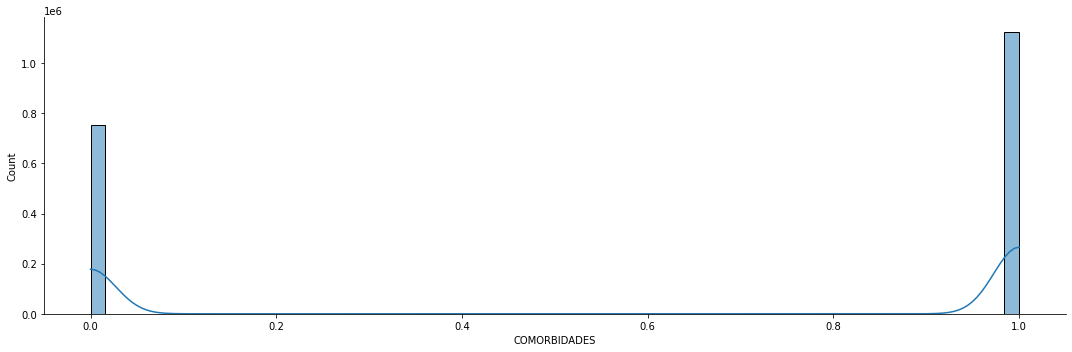

In [ ]:
sns.displot(df["COMORBIDADES"], kde = True,aspect = 3)
plt.show()

#Naive Bayes


Escolhendo as features que iremos usar no classificador:

In [ ]:
df = df[["IDADE_FASE","ONDA_FASE", 'UTI', 'FATOR_RISC', 'CLASS_TEMP_ULT_DOSE', 'COMORBIDADES', 'EVOLUCAO']]

In [ ]:
df.head(10)

,IDADE_FASE,ONDA_FASE,UTI,FATOR_RISC,CLASS_TEMP_ULT_DOSE,COMORBIDADES,EVOLUCAO
0,0,1,0,1,999999,1,0
1,0,1,0,0,999999,0,0
2,2,1,0,0,999999,0,0
3,2,1,0,0,999999,0,0
4,0,1,0,0,999999,0,0
5,0,1,0,0,999999,0,0
6,1,1,1,1,999999,1,0
7,5,1,0,1,999999,1,1
8,3,1,0,1,999999,1,0
9,0,1,0,1,999999,1,0


Verificando se as features são independentes:

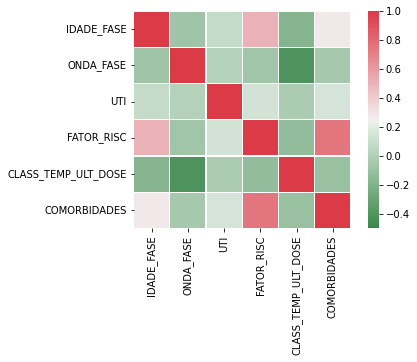

In [ ]:
corr = df.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(133, 10, as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

Percebemos pelo mapa de calor que fator de risco é bastante dependente das comorbidades e idade, portanto decidimos não utilizar essa feature no nosso classificador.

In [ ]:
df.drop(inplace = True, columns = "FATOR_RISC") 

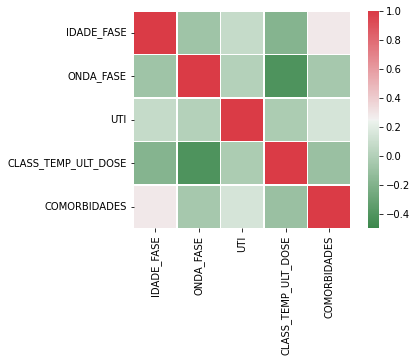

In [ ]:
corr = df.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(133, 10, as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

#Naive Bayes Categórico

In [ ]:
train, test = train_test_split(df, train_size=0.001, random_state=42)

In [ ]:
test

,IDADE_FASE,ONDA_FASE,UTI,CLASS_TEMP_ULT_DOSE,COMORBIDADES,EVOLUCAO
636671,4,2,1,999999,1,1
267016,4,2,0,999999,1,1
1162481,4,3,1,999999,1,1
1729944,3,3,0,999999,1,1
1374314,2,4,1,999999,0,0
...,...,...,...,...,...,...
882554,4,4,1,999999,0,0
441759,6,1,0,999999,1,1
750865,2,3,0,999999,1,0
552076,4,2,0,999999,1,0


In [ ]:
train

,IDADE_FASE,ONDA_FASE,UTI,CLASS_TEMP_ULT_DOSE,COMORBIDADES,EVOLUCAO
815862,4,3,0,999999,1,0
1020154,2,4,1,999999,0,1
1173917,1,4,0,999999,1,1
459297,3,1,1,999999,1,1
123618,4,1,0,999999,0,0
...,...,...,...,...,...,...
259178,5,2,1,999999,1,1
1414414,3,4,0,999999,0,0
131932,4,2,1,999999,1,0
671155,4,2,0,999999,1,0


In [ ]:
X_train = train.iloc[:,:-1].values
Y_train = train.iloc[:,-1].values

Para fazer o classificador Naive Bayes precisamos de algumas funções auxiliares:

Essa primeira função está calculando a probabilidade de a pessoa sobreviver ou não (dependendo do parametro 'alive' passado), de acordo com os dados categóricos do caso passado como parâmetro. Ou seja, ela calcula P(parametro=x|alive) para todos os parâmetros x da lista de parâmetros que temos na nossa base de dados.

In [ ]:
# probability of all parameters in params
# given that the person is alive/dead
def prob_x_given_y(data, result, params, alive, total, case): 
  prob = []
  for j in range(len(params)):
    cases = 0
    for i in range(len(data)):
      if result[i][0] == alive and data[i][j] == case[j]:
        cases+=1
    prob_x = (1+cases)/total
    prob.append(prob_x)
  return prob

In [ ]:
def multiply_list(L):
  result = 1
  for x in L:
    result*=x
  return result

E agora a função do classificador:

In [ ]:
def classify(x_train, y_results, params, x_test):
  # funcao supoe que os dados de x_test venham ordenados igual aos parametros e venham no mesmo formato de x_train
  # print(params) # ['IDADE_FASE', 'ONDA_FASE', 'CLASS_TEMP_ULT_DOSE', 'UTI', 'COMORBIDADES']
  alive = 0
  dead = 0
  total = len(y_results)
  for y in y_results:
    if y[0] == 0:
      dead+=1
    else:
      alive+=1
  pkill = dead/total        # probabilidade de uma pessoa da base de dados ter morrido
  palive = alive/total      # probabilidade de uma pessoa da base de dados nao ter morrido
  predictions = []
  for test  in x_test:
    pparamsalive = prob_x_given_y(x_train, y_results, params, 1, alive, test)   # testa para todos os parametros a probabilidade de uma pessoa com as mesmas categorias de 'test' ter sobrevivido
    pparamsdead = prob_x_given_y(x_train, y_results, params, 0, dead, test)     # testa para todos os parametros a probabilidade de uma pessoa com as mesmas categorias de 'test' ter morrido
    finalpalive =  palive*multiply_list(pparamsalive)                           # multiplica a probabilidade de sobrevivencia com as de sobreviver com todos os parametros
    finalpdead = pkill*multiply_list(pparamsdead)                               # multiplica a probabilidade de morte com as de morrer com todos os parametros passados
    if finalpalive > finalpdead:
      predictions.append(1)
    else:
      predictions.append(0)
  return predictions

Então criamos uma variavel para os resultados de nossa base de dados que iremos usar como base

In [ ]:
x_results = train.iloc[:,-1:].values

E agora uma variável para guardar a lista de parametros que estão sendo utilizados

In [ ]:
params = list(df.columns)[:-1]

Então chamamos o classificador na mesma base de dados para testa-lo, e guardamos os resultado em uma variável

In [ ]:
predictions = classify(X_train, x_results, params, X_train)

Por fim comparamos os resultados obtidos pelo classificador com os resultados que já tinhamos da nossa base para ter uma ideia da sua acurácia

In [ ]:
right = 0
for i in range(len(x_results)):
  if predictions[i] == x_results[i][0]:
    right+=1 
acc = right/len(x_results)
print('Accuracy = ', acc)

Accuracy =  0.7376263970196913


#Naive Bayes - SKLearn 

In [ ]:
from sklearn.naive_bayes import CategoricalNB
cnb = CategoricalNB()

cnb.fit(X_train, Y_train)

print("Training Accuracy: ")
test_train = cnb.score(X_train, Y_train)
print(f' {round(test_train * 100, 3)}%')

Training Accuracy: 
 73.284%
